# Main

## Mount Google Drive, Link to folder & install requirements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/IFT6756

/content/gdrive/MyDrive/IFT6756


In [3]:
!pip install -qr requirements.txt

## Imports

In [4]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

# Privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# My modules
from models import GAN, Autoencoder
from run_exp import train_autoencoder, train_gan
from utils import to_device, train_val_test_split, generate_samples, DWP, attribute_disclosure

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

## Arguments

In [5]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = False
  hidden_D: Tuple[int, ...] = (128, 64, 32)
  hidden_G: Tuple[int, ...] = (128, 256)

  # Differential privacy
  is_DP: bool = False
  sigma: float = 0.1
  delta: float = 10e-3

  # Optimization
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 0.00005
  epochs: int = 50

  # Miscellaneous
  device: str = 'cpu'
  decoder = torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")
  verbose: bool = True


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 64
  hidden: Tuple[int, ...] = (9,16,32)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [6]:
# Load data 
"""
# Uncomment this block to create train, val, test sets from the data
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, val, test = train_val_test_split(df)
"""

# Load data 
train_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train.csv', index_col=0)
val_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/val.csv', index_col=0)
test_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test.csv', index_col=0)
# To numpy arrays 
train = train_df.values
val = val_df.values
test = test_df.values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
val_tensor = torch.tensor(val, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

## Pretraining the decoder

### Initialization

In [7]:
# # Experiment's details
# args = Arguments_ae(batch_size=16,
#                     input_dim=9,
#                     latent_dim=64,
#                     hidden=(9,16,32),
#                     lr=1e-3,
#                     epochs=50,
#                     device="cuda")

In [8]:
# # DataLoader
# train_loader = DataLoader(train_tensor,
#                               batch_size=args.batch_size,
#                               shuffle=False)
# val_loader = DataLoader(val_tensor,
#                             batch_size=args.batch_size,
#                             shuffle=False)

In [9]:
# # Model
# autoencoder = Autoencoder(args)
# print(autoencoder)

### Training

In [10]:
# # Training
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
# train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

In [11]:
# # Plot validation and training losses
# epochs = range(1, args.epochs+1)
# plt.figure(figsize=(15, 7))
# plt.title("Mean square error (MSE) against the epochs for the training and validation set")
# plt.plot(epochs, autoencoder.logs["train loss"], label="training")
# plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
# plt.xticks(epochs)
# plt.ylim((0, 50))
# plt.legend(loc=1)
# plt.show()

In [12]:
# # Examples of reconstructions on validation set
# n = 10
# idx = random.sample(range(len(val)), n)
# for i in idx:
#   example = val_tensor[i].to(args.device)
#   print("\nTarget")
#   print(example)
#   print("Reconstruction")
#   print(autoencoder.decoder(autoencoder.encoder(example)))
#   print("Encoding")
#   print(autoencoder.encoder(example))


### Save decoder

In [13]:
# torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")

## Training WGAN

### Initialization

In [17]:
args = Arguments_gan(epochs=25,
                     hidden_D=(64,),
                     hidden_G=(128,),
                     is_DP=False,
                     is_finetuning=True,
                     device="cuda",
                     verbose=False)

In [18]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(val_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [19]:
# Model
gan = GAN(args)
gan.to(args.device)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=9, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=9, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training

In [20]:
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

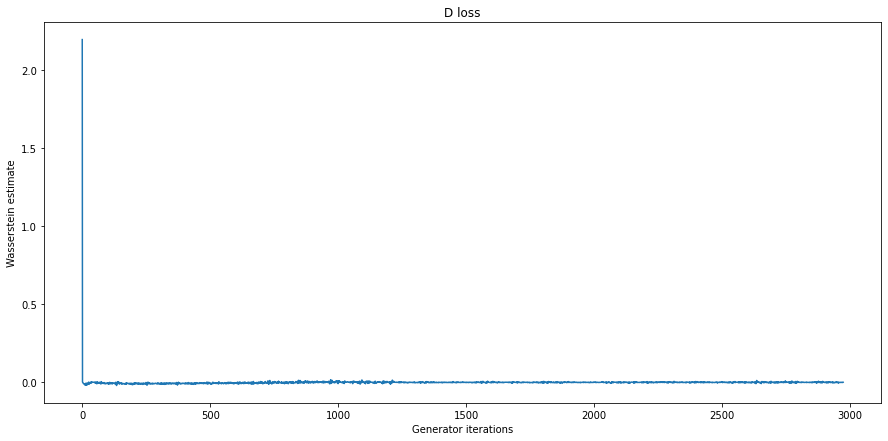

In [21]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

Looks like we are converging really fast...

In [22]:
gan.logs["approx. EM distance"][-10:]

[-0.0025839931331574917,
 -0.001566295512020588,
 -0.0007834918797016144,
 -0.0017967098392546177,
 -0.0013458403991535306,
 -0.0015238202176988125,
 -0.0009797431994229555,
 -0.002428909298032522,
 -0.0016142355743795633,
 -0.0009438889101147652]

## Model Evaluation

### Computing $\epsilon$

we can use the `compute_dp_sgd_privacy` script in the **TensorFlow Privacy** library to calculate the privacy loss $\epsilon$ for a given data set and training regime. `N` corresponds to the number of data points, and `noise_multiplier` corresponds to `sigma`. `batch_size` and `epochs` are the same as in training. `delta` is the tolerance probability for privacy loss beyond $\epsilon$.

 

In [24]:
if args.is_DP:
    print(compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train.shape[0],
                                              batch_size=args.batch_size,
                                              noise_multiplier=args.sigma,
                                              epochs=args.epochs,
                                              delta=args.delta))


### Visual examples

In [25]:
batch_synthetic = generate_samples(gan.G, 25, args)
print(batch_synthetic)

[[ 6.  4. 40.  0.  2.  2.  3.  4.  1.]
 [ 2.  3. 47.  1.  2.  1.  2.  3.  2.]
 [ 7.  5. 40.  0.  4.  2.  3.  4.  0.]
 [ 5.  3. 28.  2.  1.  2.  3.  2.  2.]
 [ 8.  5.  9.  2.  0.  2.  4.  2.  1.]
 [ 4.  5. 14.  0.  1.  2.  3.  3.  2.]
 [ 5.  1. 45.  1.  1.  1.  2.  2.  1.]
 [ 3.  4. 49.  4.  0.  2.  3.  3.  2.]
 [ 6.  5. 47.  1.  2.  2.  3.  3.  1.]
 [ 4.  4. 45.  0.  3.  1.  2.  3.  1.]
 [ 2.  3. 37.  8.  0.  2.  3.  3.  3.]
 [ 7.  4.  9.  0.  2.  2.  4.  3.  1.]
 [ 1.  6.  5.  6.  0.  2.  3.  4.  3.]
 [ 5.  4. 30.  3.  0.  2.  4.  3.  2.]
 [ 6.  2. 23.  0.  2.  1.  3.  2.  1.]
 [ 4.  5.  5.  5.  0.  2.  3.  2.  2.]
 [ 3.  3. 37.  1.  2.  1.  2.  3.  2.]
 [ 6.  4. 13.  2.  0.  2.  3.  2.  1.]
 [ 1.  2. 61.  3.  1.  1.  2.  3.  2.]
 [ 3.  1. 48.  0.  3.  1.  1.  3.  1.]
 [ 4.  6. 27.  1.  1.  2.  3.  3.  2.]
 [ 3.  4. 25.  0.  3.  1.  2.  3.  2.]
 [ 3.  4. 37.  4.  0.  1.  3.  3.  2.]
 [ 2.  1. 64.  2.  1.  1.  1.  3.  2.]
 [ 1.  3. 41.  0.  3.  1.  2.  4.  2.]]


### Compare the marginals

Generation of an equal number  of synthetic examples as in validation set

In [26]:
batch_synthetic = generate_samples(gan.G, val_df.shape[0], args)
batch_synthetic_df = pd.DataFrame(batch_synthetic, columns=val_df.columns)

Some statistics for each dimension

In [27]:
val_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,4.381199,3.580804,38.176659,1.640020,2.024673,1.500864,2.771527,2.881322,1.332346
std,1.279735,1.444155,22.861754,1.826899,2.268694,0.500061,0.826874,1.103919,0.708036
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000


In [28]:
batch_synthetic_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,4.236862,3.631384,37.948433,1.584259,2.075746,1.580558,2.729089,2.834690,1.342956
std,1.886494,1.775047,18.934074,2.176461,2.078047,0.493518,1.014040,0.664878,0.562773
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,3.000000,2.000000,25.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000
50%,4.000000,3.000000,38.000000,0.000000,2.000000,2.000000,3.000000,3.000000,1.000000
75%,5.000000,5.000000,51.000000,3.000000,4.000000,2.000000,3.000000,3.000000,2.000000
max,11.000000,10.000000,101.000000,12.000000,9.000000,2.000000,6.000000,5.000000,3.000000


Visual comparison of each dimension's distribution using histograms.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


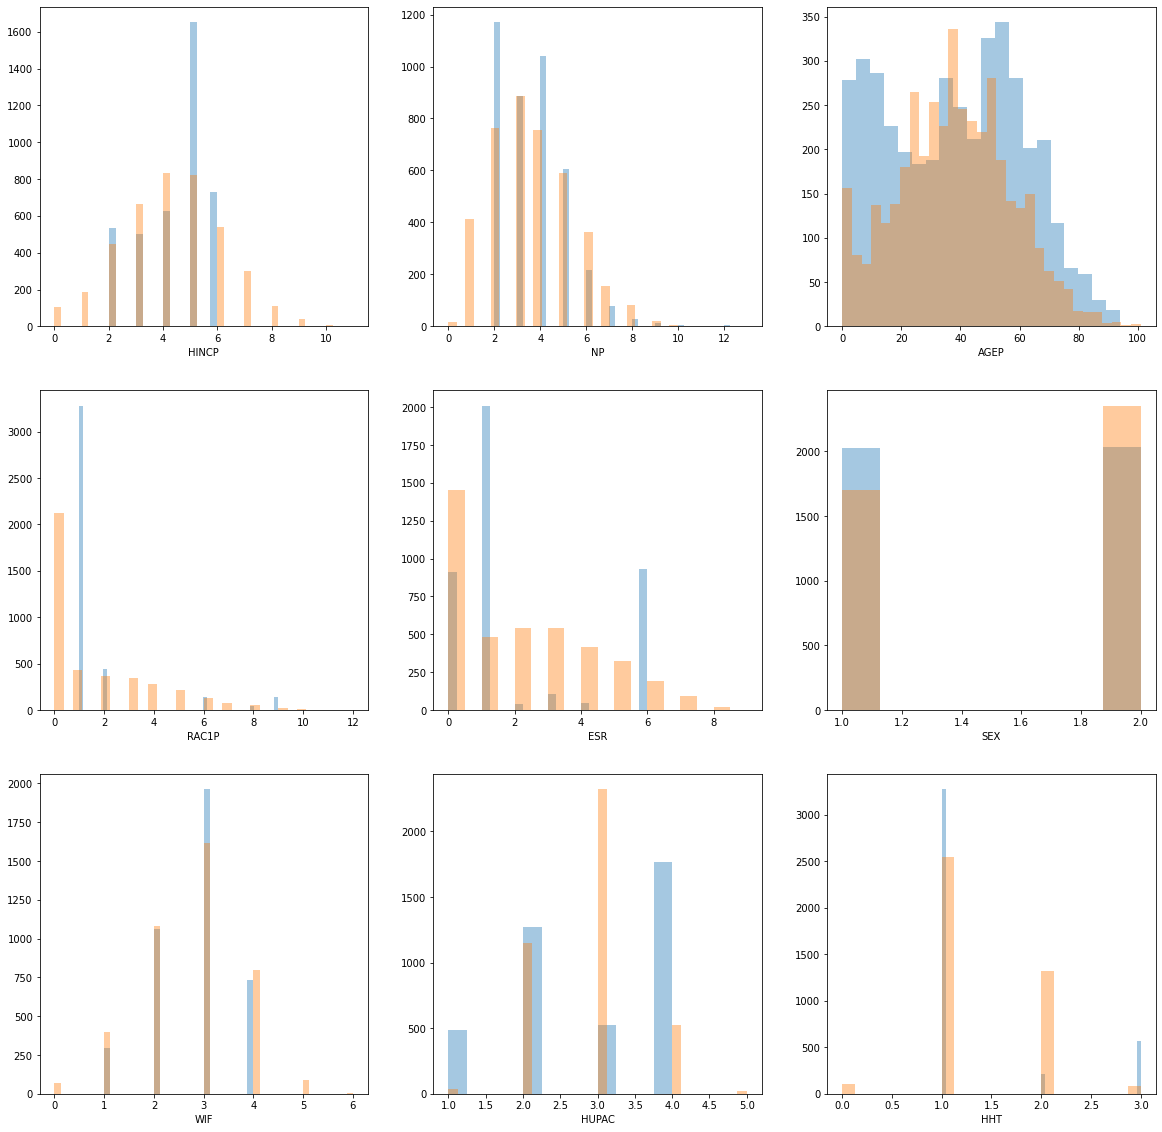

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
k = 0
col = val_df.columns
for i in range(3):
  for j in range(3):
    sns.distplot(val_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic_df[col[k]], kde=False, ax=ax[i, j])
    k += 1

### Dimension-wise prediction

After training the model with real training dataset to generate synthetic population, we choose one dimension to be the label. The remaining dimensions are used as features to train two classifier with same hyperparameters to predict the isolated dimension. Then, we use the two classifiers to predict de test set. We can assume that the close the performance of the classifiers, the better the quality of the synthetic samples.
(https://arxiv.org/pdf/1703.06490.pdf)

In [30]:
# Generate synthetic train samples
train_synthetic = generate_samples(gan.G, train_df.shape[0], args)
train_synthetic = pd.DataFrame(train_synthetic, columns=train_df.columns)

In [31]:
f1_scores = []
for col in train_df.columns:
    f1_scores.append(DWP(train_df, train_synthetic, val_df, col))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
for i, f1 in enumerate(f1_scores):
    f1_real, f1_synthetic = f1
    print(f"Dim:{train_df.columns[i]},\t F1 real: {f1_real:.3f},\t F1 synthetic: {f1_synthetic:.3f}")

Dim:HINCP,	 F1 real: 0.306,	 F1 synthetic: 0.301
Dim:NP,	 F1 real: 0.423,	 F1 synthetic: 0.293
Dim:AGEP,	 F1 real: 0.040,	 F1 synthetic: 0.013
Dim:RAC1P,	 F1 real: 0.726,	 F1 synthetic: 0.463
Dim:ESR,	 F1 real: 0.784,	 F1 synthetic: 0.529
Dim:SEX,	 F1 real: 0.537,	 F1 synthetic: 0.531
Dim:WIF,	 F1 real: 0.526,	 F1 synthetic: 0.447
Dim:HUPAC,	 F1 real: 0.630,	 F1 synthetic: 0.113
Dim:HHT,	 F1 real: 0.741,	 F1 synthetic: 0.682


## Première considération sur la confidentialité

Attribute disclosure: 
On échantillonne $m$ exemples de l'ensemble d'entraînement. Pour chaque exemple $r$, on suppose que l'attaquant ne connait pas $s$ attributs déterminés aléatoirement. 

L'attaquant essaie de retrouver les attributs inconnnus de $r$ de la façon suivante. Il trouve les $k$ plus proche voisins de $r$ dans l'ensemble de données synthétiques. Les attributs inconnus de $r$ sont estimés par un vote majoritaire des attributs des $k$ plus proches voisins. Pour évaluer la classification, on compte simplement le nombre d'erreurs et de là on peut retrouver le ratio d'éléments retrouvés par rapport au nombre total d'éléments qu'on voulait retrouvé (accuracy). **(Quelque chose de moins naïf?)**

Ce processus est répété pour les $m$ exemples de l'ensemble d'entraînement. On peut déterminer le nombre moyen d'attributs retrouvés. Notons que $s$ attributs sont choisis aléatoirement pour chaque exemple. L'attaquant peut connaître différents attributs $s$ pour différents exemples.

**Décrire les défauts de cette méthode ?**

Décrire l'impact de la taille du dataset, du nombre d'attribut connu, ...
**Comparer avec le train_set directement**

### Impact du nombre d'attributs connus

Pour un nombre fixe de données synthétiques. On trace la courbe de l'accuracy (pourcentage d'attributs effectivement retrouvés)

In [33]:
print(f"Nombre total d'attributs: {train_df.columns.shape[0]}")

Nombre total d'attributs: 9


In [34]:
# Generate synthetic train samples
synthetic = generate_samples(gan.G, train_df.shape[0], args)
synthetic_df = pd.DataFrame(train_synthetic, columns=train_df.columns)

In [35]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8]  # to be guess
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, synthetic_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

In [36]:
acc

{1: [0.39,
  0.35,
  0.3433333333333334,
  0.33999999999999997,
  0.31399999999999995,
  0.29000000000000004,
  0.26,
  0.28500000000000003],
 5: [0.33999999999999997,
  0.31499999999999995,
  0.31999999999999995,
  0.3225,
  0.274,
  0.32166666666666666,
  0.27428571428571424,
  0.2825],
 10: [0.25,
  0.28,
  0.32333333333333336,
  0.27749999999999997,
  0.30800000000000005,
  0.31166666666666665,
  0.2985714285714286,
  0.27375000000000005],
 100: [0.43000000000000005,
  0.31499999999999995,
  0.31333333333333335,
  0.26249999999999996,
  0.278,
  0.32666666666666666,
  0.26857142857142857,
  0.28625]}

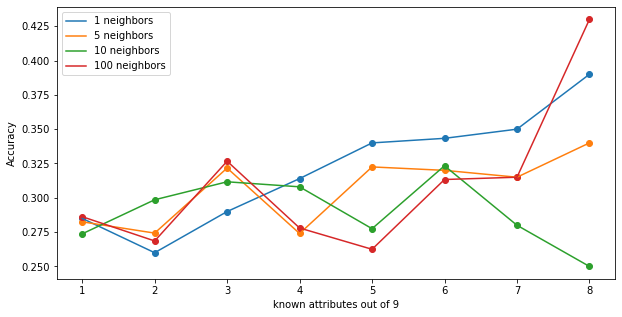

In [37]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()